In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("/mnt/datadisk/lizhongzhan/SpaMultiOmics/main/")
import scanpy as sc
import pandas as pd
import numpy as np
import os
import networkx as nx
from switch import SWITCH, preprocess
from itertools import chain

In [2]:
os.chdir("../../../DATA/H3k27ac/")

Preprocess

In [3]:
rna = sc.read_h5ad("rna.h5ad")
atac = sc.read_h5ad("peakMat.h5ad")
atac.obs_names = [i.split("-")[0] for i in atac.obs_names]
comm = list(set(rna.obs_names) & set(atac.obs_names))
atac = atac[comm]
rna = rna[comm]
atac.obsm["spatial"] = rna.obsm["spatial"].copy()
(rna.obs_names==atac.obs_names).all()

True

In [4]:
preprocess.get_gene_annotation(rna, 
                    gtf="../../DATA/Mouse_embryo/gencode.vM25.annotation.gtf.gz",
                    gtf_by="gene_name",
                    drop_na=True
)

- INFO - 3280 genes were not annotated and dropped.


In [5]:
rna.layers["counts"] = rna.X.copy()
sc.pp.highly_variable_genes(rna, n_top_genes=3000, flavor="seurat_v3", layer="counts")

In [6]:
split = atac.var_names.str.split(r"[:-]")
atac.var["chrom"] = split.map(lambda x: x[0])
atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
## print(i.var)

In [7]:
print(atac.shape[1])
sc.pp.filter_genes(atac, min_cells=atac.shape[0]*0.01)
print(atac.shape[1])

607706
184225


In [8]:
guidance = preprocess.rna_anchored_guidance_graph(rna, atac)
len(atac.var[atac.var["highly_variable"]==True])

window_graph: 100%|██████████| 20135/20135 [00:02<00:00, 8173.44it/s]


20512

In [9]:
atac = atac[:,atac.var["highly_variable"]]
sc.pp.filter_cells(atac, min_counts=1)

In [10]:
guidance_hvf = guidance.subgraph(chain(
   rna.var.query("highly_variable").index,
   atac.var.query("highly_variable").index
)).copy()
# nx.write_graphml(guidance_hvf, "guidance_hvf.graphml.gz")

In [11]:
# rna.write("rna-pp.h5ad")
# atac.write("atac-pp.h5ad")

In [12]:
# rna = sc.read_h5ad("rna-pp.h5ad")
# atac = sc.read_h5ad("atac-pp.h5ad")
# guidance_hvf = nx.read_graphml("guidance_hvf.graphml.gz")

Training

In [13]:
preprocess.config_data(
    rna, "NB",
    use_highly_variable=True,
    use_layer="counts",
)
preprocess.config_data(
    atac, "POIS",
    use_highly_variable=True, 
)

In [14]:
preprocess.Cal_Spatial_Net(rna, rad_cutoff=55, model="Radius")
preprocess.Cal_Spatial_Net(atac, rad_cutoff=55, model="Radius")

- INFO - Calculating 'spatial' graph.
The graph contains 105214 edges, 9365 spots.
11.2348 neighbors per spot on average.
- INFO - Calculating 'spatial' graph.
The graph contains 105214 edges, 9365 spots.
11.2348 neighbors per spot on average.


In [15]:
model = SWITCH(adatas={"rna": rna, "atac": atac}, vertices=sorted(guidance_hvf.nodes), h_depth_dsc=2)

- INFO - Set random seed to 0
- INFO - GPU available: True, used device: GPU 0


In [16]:
model.compile()

In [17]:
model.pretrain(adatas={"rna": rna, "atac": atac}, graph=guidance_hvf, 
             max_epochs=2100, dsc_k=4, warmup=True)

- INFO - Prepare data for training.
- INFO - Pretraining with full batch.
- INFO - Epoch 1 : dsc_loss=0.31, gen_loss=0.485
- INFO - Epoch 2 : dsc_loss=0.53, gen_loss=0.441
- INFO - Epoch 3 : dsc_loss=0.589, gen_loss=0.42
- INFO - Epoch 4 : dsc_loss=0.69, gen_loss=0.403
- INFO - Epoch 5 : dsc_loss=0.683, gen_loss=0.39
- INFO - Epoch 6 : dsc_loss=0.678, gen_loss=0.384
- INFO - Epoch 7 : dsc_loss=0.675, gen_loss=0.38
- INFO - Epoch 8 : dsc_loss=0.688, gen_loss=0.376
- INFO - Epoch 9 : dsc_loss=0.685, gen_loss=0.374
- INFO - Epoch 10 : dsc_loss=0.69, gen_loss=0.371
- INFO - Epoch 11 : dsc_loss=0.67, gen_loss=0.371
- INFO - Epoch 12 : dsc_loss=0.684, gen_loss=0.369
- INFO - Epoch 13 : dsc_loss=0.689, gen_loss=0.368
- INFO - Epoch 14 : dsc_loss=0.673, gen_loss=0.367
- INFO - Epoch 15 : dsc_loss=0.69, gen_loss=0.366
- INFO - Epoch 16 : dsc_loss=0.689, gen_loss=0.366
- INFO - Epoch 17 : dsc_loss=0.69, gen_loss=0.365
- INFO - Epoch 18 : dsc_loss=0.69, gen_loss=0.365
- INFO - Epoch 19 : dsc_loss

In [18]:
model.train(adatas={"rna": rna, "atac": atac}, graph=guidance_hvf, max_epochs=1100, dsc_k=8,
            warmup=True, warmup_kwargs={"step":50, "gamma":0.75})

- INFO - Training with full batch.
- INFO - Epoch 1 : dsc_loss=0.734, gen_loss=0.815, cycle_loss=0.373, align_loss=0.779
- INFO - Epoch 2 : dsc_loss=0.696, gen_loss=0.811, cycle_loss=0.372, align_loss=0.762
- INFO - Epoch 3 : dsc_loss=0.693, gen_loss=0.809, cycle_loss=0.371, align_loss=0.756
- INFO - Epoch 4 : dsc_loss=0.713, gen_loss=0.807, cycle_loss=0.37, align_loss=0.755
- INFO - Epoch 5 : dsc_loss=0.692, gen_loss=0.807, cycle_loss=0.37, align_loss=0.752
- INFO - Epoch 6 : dsc_loss=0.694, gen_loss=0.806, cycle_loss=0.37, align_loss=0.752
- INFO - Epoch 7 : dsc_loss=0.693, gen_loss=0.806, cycle_loss=0.37, align_loss=0.752
- INFO - Epoch 8 : dsc_loss=0.693, gen_loss=0.806, cycle_loss=0.37, align_loss=0.751
- INFO - Epoch 9 : dsc_loss=0.693, gen_loss=0.806, cycle_loss=0.37, align_loss=0.751
- INFO - Epoch 10 : dsc_loss=0.695, gen_loss=0.806, cycle_loss=0.369, align_loss=0.751
- INFO - Epoch 11 : dsc_loss=0.694, gen_loss=0.805, cycle_loss=0.369, align_loss=0.751
- INFO - Model training

In [19]:
rna.obsm["SWITCH"] = model.encode_data("rna",rna)
atac.obsm["SWITCH"] = model.encode_data("atac",atac)

In [53]:
combined = sc.concat([rna, atac], label="omics")
sc.pp.neighbors(combined, use_rep="SWITCH", n_neighbors=30, metric="cosine")
sc.tl.umap(combined, min_dist=0.3)

In [54]:
sc.tl.leiden(adata=combined, resolution=1., key_added="leiden")
print(len(set(combined.obs["leiden"])))

18


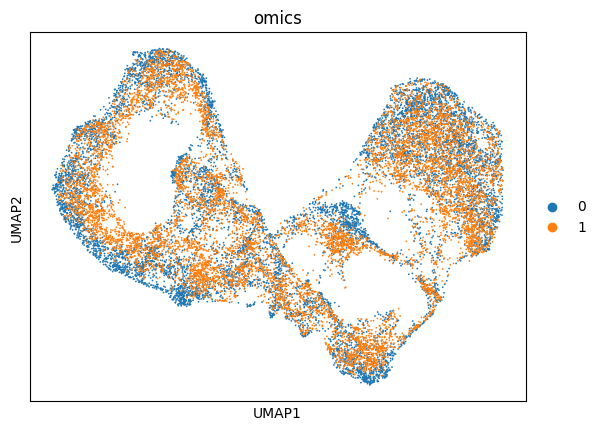

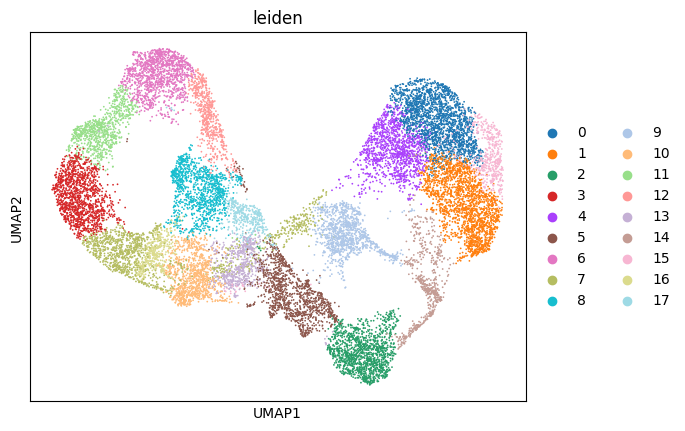

In [55]:
sc.pl.umap(combined, color="omics")
sc.pl.umap(combined, color="leiden")

In [56]:
t_rna = combined[combined.obs["omics"]=="0",]
t_atac = combined[combined.obs["omics"]=="1",]

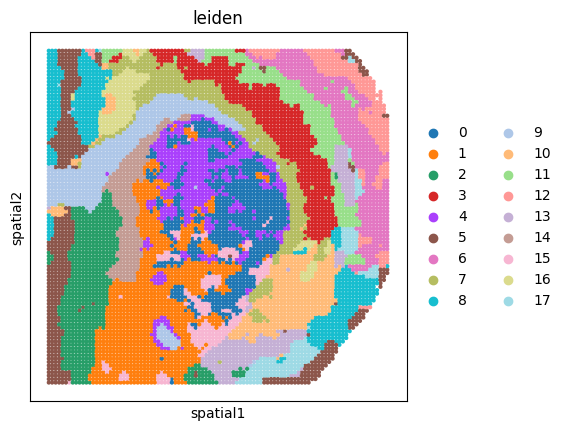

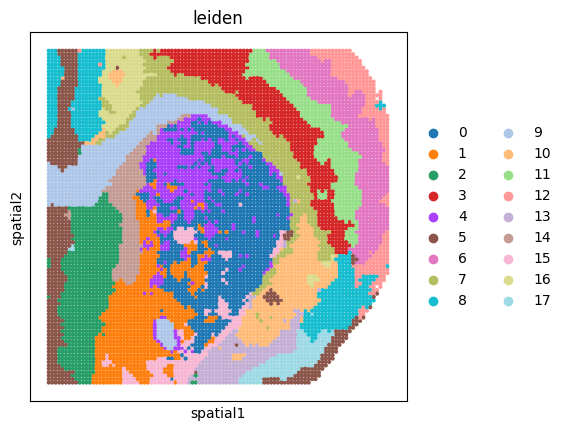

In [57]:
sc.pl.spatial(t_atac, color="leiden",spot_size=34)
sc.pl.spatial(t_rna, color="leiden",spot_size=34)

In [58]:
import scipy
def foscttm(
        x: np.ndarray, y: np.ndarray, **kwargs
):
    d = scipy.spatial.distance_matrix(x, y, **kwargs)
    n1, _ = d.shape
    true_matching = np.arange(n1)
    mask = (d.T < d[np.arange(n1), true_matching]).T
    return np.mean(np.mean(mask, axis=1))
x=foscttm(t_rna.obsm["SWITCH"], t_atac.obsm["SWITCH"])
x

0.03327592571424825

In [59]:
# embed = pd.DataFrame(combined.obsm["SWITCH"])
# embed.to_csv("rep1/SWITCH_embed.csv")
# umap = pd.DataFrame(combined.obsm["X_umap"])
# umap.to_csv("rep1/SWITCH_umap.csv")
# cluster = pd.DataFrame(combined.obs["leiden"])
# cluster.to_csv("rep1/SWITCH_cluster.csv")